<a href="https://colab.research.google.com/github/yaraahmed004/Greenhouse-Pest-Detection/blob/main/DINOSAMSAHICLIPwithvideo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Dec 23 21:51:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   68C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
import sys
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
%cd /content/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn
!sed -i 's/value.type()/value.scalar_type()/g' ms_deform_attn_cuda.cu
!sed -i 's/value.scalar_type().is_cuda()/value.is_cuda()/g' ms_deform_attn_cuda.cu

/content/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn


In [ ]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .

/content
fatal: destination path 'GroundingDINO' already exists and is not an empty directory.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done


In [ ]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-50jxp4e6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-50jxp4e6
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [ ]:
!pip uninstall -y supervision
!pip install -q supervision==0.24.0
# !pip install -q supervision --upgrade

import supervision as sv
print(sv.__version__)

Found existing installation: supervision 0.24.0
Uninstalling supervision-0.24.0:
  Successfully uninstalled supervision-0.24.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino 0.1.0 requires supervision==0.4.0, but you have supervision 0.24.0 which is incompatible.
0.24.0


In [ ]:
dir(sv)

['BackgroundOverlayAnnotator',
 'BaseDataset',
 'BlurAnnotator',
 'BoundingBoxAnnotator',
 'BoxAnnotator',
 'BoxCornerAnnotator',
 'ByteTrack',
 'CSVSink',
 'CircleAnnotator',
 'ClassificationDataset',
 'Classifications',
 'Color',
 'ColorAnnotator',
 'ColorLookup',
 'ColorPalette',
 'ConfusionMatrix',
 'CropAnnotator',
 'DetectionDataset',
 'Detections',
 'DetectionsSmoother',
 'DotAnnotator',
 'EdgeAnnotator',
 'EllipseAnnotator',
 'FPSMonitor',
 'HaloAnnotator',
 'HeatMapAnnotator',
 'IconAnnotator',
 'ImageSink',
 'InferenceSlicer',
 'JSONSink',
 'KeyPoints',
 'LMM',
 'LabelAnnotator',
 'LineZone',
 'LineZoneAnnotator',
 'LineZoneAnnotatorMulticlass',
 'MaskAnnotator',
 'MeanAveragePrecision',
 'OrientedBoxAnnotator',
 'OverlapFilter',
 'PercentageBarAnnotator',
 'PixelateAnnotator',
 'Point',
 'PolygonAnnotator',
 'PolygonZone',
 'PolygonZoneAnnotator',
 'Position',
 'Rect',
 'RichLabelAnnotator',
 'RoundBoxAnnotator',
 'TraceAnnotator',
 'TriangleAnnotator',
 'VertexAnnotator',
 

In [ ]:
GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [ ]:
%cd {HOME}
!mkdir -p {HOME}/data

/content


In [ ]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


In [ ]:
GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


In [ ]:
%cd {HOME}
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [ ]:
SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [ ]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model, load_model, load_image, predict, annotate

grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

/content/GroundingDINO


final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


In [ ]:
SAM_ENCODER_VERSION = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

In [ ]:
import cv2
import torch
import numpy as np
import supervision as sv
from typing import List
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt
import math
from typing import Tuple, Optional

In [ ]:
def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

In [ ]:
def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)



Loading Our Aphid Dataset

In [ ]:
!pip install roboflow

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="8km2xCBxS2nMg5dTkLNl")
project = rf.workspace("computer-vision-project-1l7i3").project("aphids-z5df4")
version = project.version(1)
dataset = version.download("yolov8")

DATA_YAML_PATH = os.path.join(dataset.location, "data.yaml")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to aphids-1 in yolov8:: 100%|██████████| 412/412 [00:00<00:00, 5863.35it/s]


Using Image Input

In [ ]:
SOURCE_IMAGE_PATH = f"/content/data/whitefly7.jpg"
CLASSES = ['whitefly']
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.2

Using Video Input

In [ ]:
CLASSES = ['small green insect on leaf']
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.2

With CLIP and SAHI - Video







In [ ]:
import torch
import cv2
import numpy as np
import supervision as sv
from transformers import CLIPProcessor, CLIPModel
from PIL import Image

# --- 1. CONFIGURATION & MODELS ---
SOURCE_VIDEO_PATH = "/content/data/aphids_vid.mp4"
TARGET_VIDEO_PATH = "/content/data/aphid_result_with_clipandsahi2.mp4"
CLASSES = ['insect']
CLIP_PROMPTS = ["insect on a leaf", "a piece of dust or glare"]

# Load CLIP (Verify what GroundingDINO finds)
print("Loading CLIP...")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Annotators
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
label_annotator = sv.LabelAnnotator()

# list to store every frame for graphs
video_stats = []
all_video_detections = []

# --- 2. THE PROCESSING LOGIC ---

#integrating sahi

def sahi_dino_callback(image_slice: np.ndarray) -> sv.Detections:
    return grounding_dino_model.predict_with_classes(
        image=image_slice,
        classes=enhance_class_name(CLASSES),
        box_threshold=0.3,
        text_threshold=0.2
    )

slicer = sv.InferenceSlicer(
    callback=sahi_dino_callback,
    slice_wh=(512, 512),   # Smaller slices help find tiny insects
    overlap_wh=(100, 100),
    overlap_ratio_wh = None
)

def process_frame(image: np.ndarray, index: int) -> np.ndarray:
    # A. Detect with SAHI + GroundingDINO
    # Slicer automatically cuts the frame, detects insects, and stitches results
    detections = slicer(image)

    # Run Non-Max Suppression (NMS) to merge duplicate detections at slice boundaries
    detections = detections.with_nms(threshold=0.5)

    # Filter out None IDs (Standard safety check)
    if detections.class_id is not None:
        detections = detections[detections.class_id != None]

    if len(detections) == 0:
        return image

    # B. Verify with CLIP
    verified_indices = []
    clip_confidences = []

    for i, xyxy in enumerate(detections.xyxy):
        # Crop detection from the original frame
        x1, y1, x2, y2 = map(int, xyxy)
        crop = image[y1:y2, x1:x2]

        if crop.size == 0: continue

        # CLIP preprocessing
        crop_rgb = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        inputs = clip_processor(text=CLIP_PROMPTS, images=crop_rgb, return_tensors="pt", padding=True).to(DEVICE)

        with torch.no_grad():
            outputs = clip_model(**inputs)
            probs = outputs.logits_per_image.softmax(dim=1)
            target_prob = probs[0][0].item()

        # Threshold check (0.6 is a good balance for CLIP)
        if target_prob > 0.6:
            verified_indices.append(i)
            clip_confidences.append(target_prob)

    # Filter detections to only those CLIP confirmed
    if not verified_indices:
        return image

    detections = detections[np.array(verified_indices)]

    # C. Segment with SAM (Only verified objects)
    detections.mask = segment(
        sam_predictor=sam_predictor,
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        xyxy=detections.xyxy
    )

    # D. Annotate
    annotated_frame = image.copy()
    annotated_frame = mask_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)

    labels = [
        f"Verified Insect | CLIP: {clip_conf:.2f}"
        for clip_conf in clip_confidences
    ]

    # Stats Tracking
    current_count = len(detections)
    video_stats.append({
        'frame': index,
        'count': current_count,
        'confidence': np.mean(detections.confidence) if current_count > 0 else 0,
        'clip_score': np.mean(clip_confidences) if clip_confidences else 0
    })

    all_video_detections.append(detections)

    return label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

# --- 3. RUN ---
print("Starting Video Processing with CLIP Verification...")
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=process_frame
)
print(f"Video saved to: {TARGET_VIDEO_PATH}")

Loading CLIP...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Starting Video Processing with CLIP Verification...


The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Video saved to: /content/data/aphid_result_with_clipandsahi2.mp4


Statistics

In [ ]:
sv_dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=os.path.join(dataset.location, "train", "images"),
    annotations_directory_path=os.path.join(dataset.location, "train", "labels"),
    data_yaml_path=DATA_YAML_PATH
)
predictions = []
targets = []

# Use the images from your downloaded Roboflow dataset
for image_path, image in sv_dataset.images.items():
    # 1. Run your SAHI Slicer
    detections = slicer(image)
    detections = detections.with_nms(threshold=0.5)

    # 2. Run your CLIP filtering logic here
    if len(detections) > 0:
        verified_indices = []
        clip_confidences = []

        for i, xyxy in enumerate(detections.xyxy):
            # Crop the object from the full image
            x1, y1, x2, y2 = map(int, xyxy)
            crop = image[y1:y2, x1:x2]

            if crop.size == 0: continue

            # Convert BGR (OpenCV) to RGB (PIL) for CLIP
            crop_rgb = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))

            # Run CLIP
            inputs = clip_processor(text=CLIP_PROMPTS, images=crop_rgb, return_tensors="pt", padding=True).to(DEVICE)
            with torch.no_grad():
                outputs = clip_model(**inputs)
                probs = outputs.logits_per_image.softmax(dim=1)
                # Probability of the target prompt (e.g., "insect on a leaf")
                target_prob = probs[0][0].item()

            # Filter by CLIP threshold
            if target_prob > 0.6: # Matches your video threshold
                verified_indices.append(i)
                clip_confidences.append(target_prob)

        # Update detections to only keep CLIP-verified objects
        if verified_indices:
            detections = detections[np.array(verified_indices)]
        else:
            detections = sv.Detections.empty()

    predictions.append(detections)
    targets.append( .annotations[image_path])

# 3. Calculate Mean Average Precision
map_metric = sv.MeanAveragePrecision.from_detections(predictions, targets)
print(f"Aphid Detection mAP: {map_metric.map50:.2f}")

images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
The channel dimension is ambiguous. Got image shape (3, 3, 3). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


Aphid Detection mAP: 0.51


In [ ]:
import matplotlib.pyplot as plt

map_metric.plot()
plt.title("Precision-Recall curve: Aphids")
plt.show()

AttributeError: 'MeanAveragePrecision' object has no attribute 'plot'

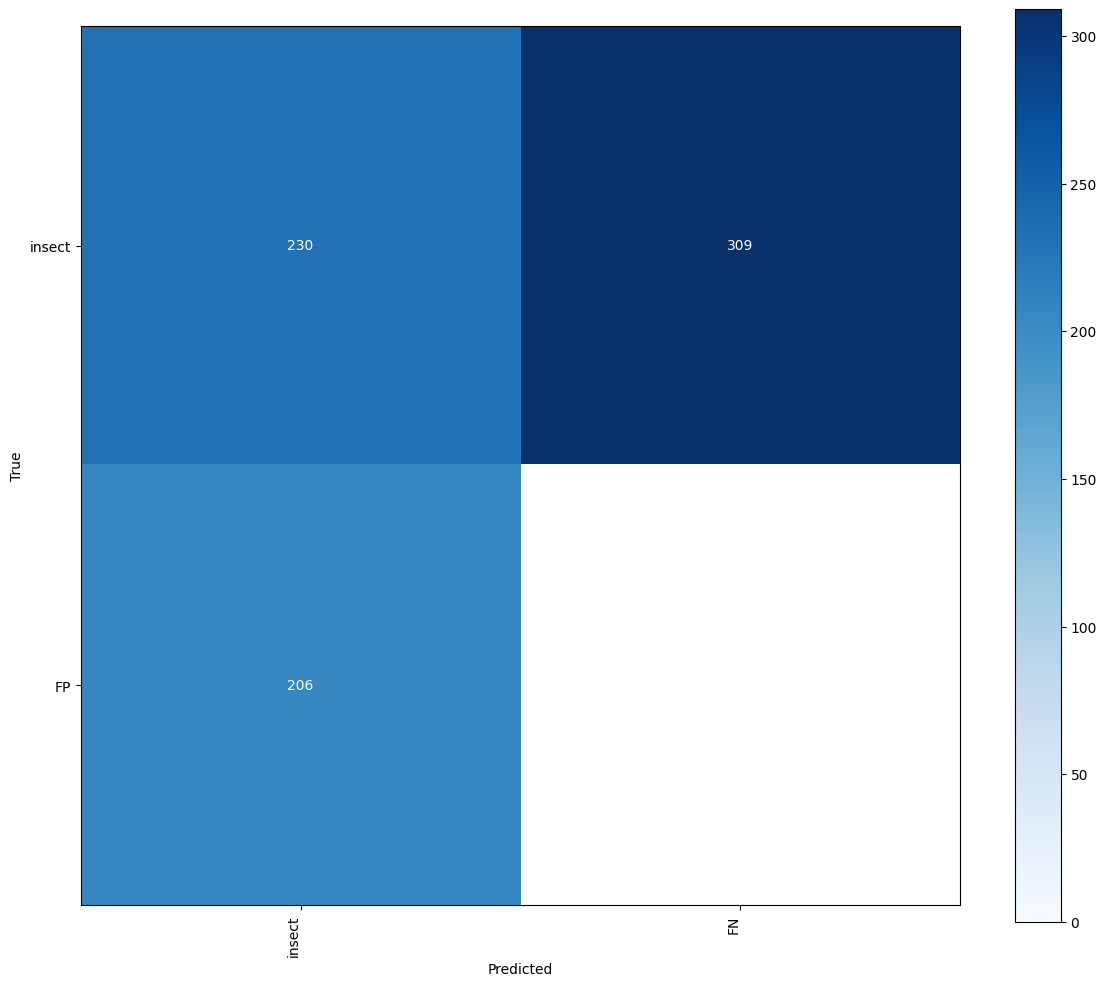

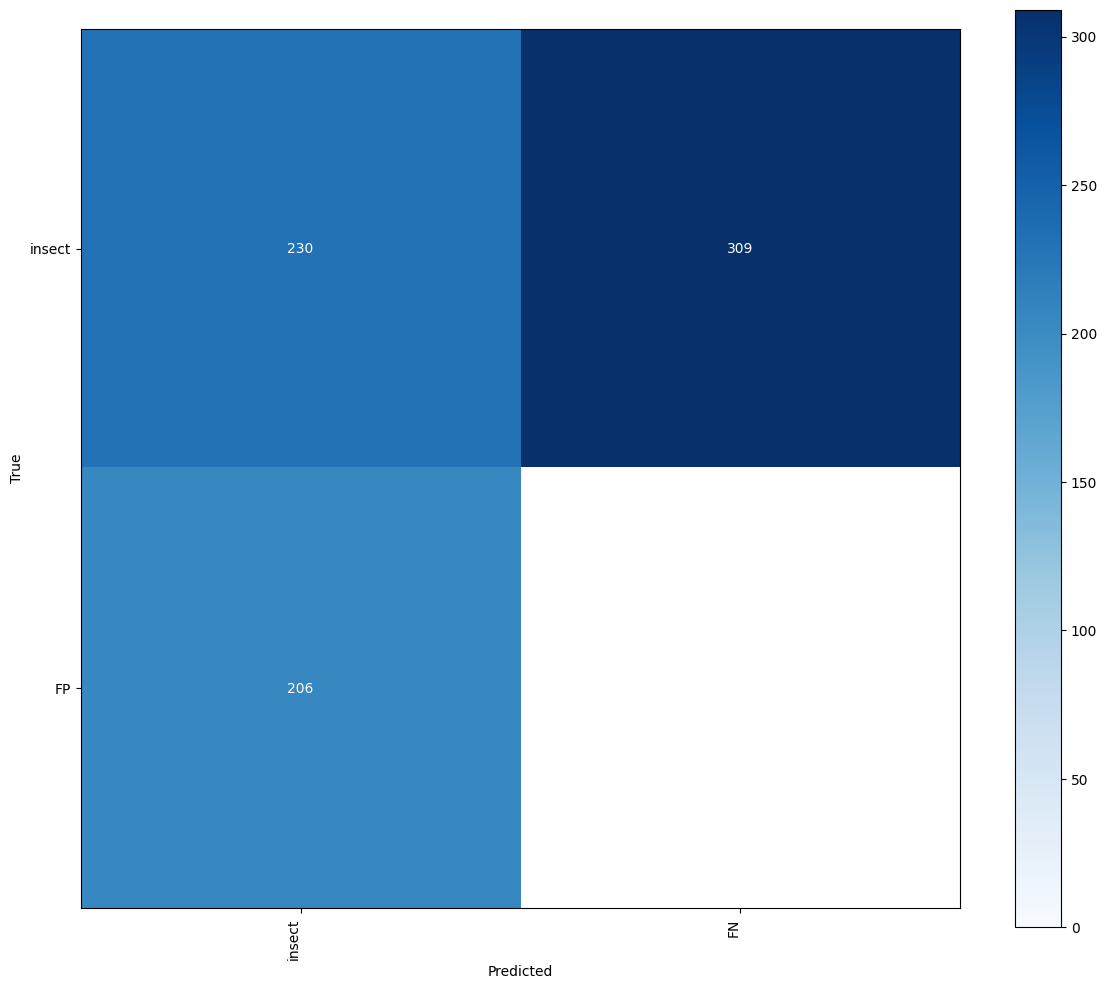

In [ ]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)
confusion_matrix.plot()

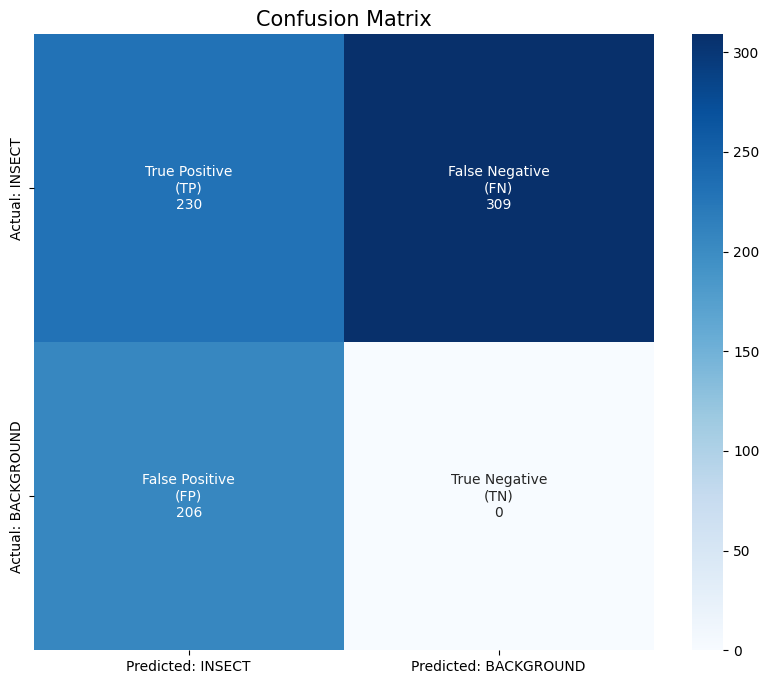

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = np.array([[230, 309],
                [206, 0]])
box_labels = np.array([
    [f"True Positive\n(TP)\n230", f"False Negative\n(FN)\n309"],
    [f"False Positive\n(FP)\n206", f"True Negative\n(TN)\n0"]
])

plt.figure(figsize=(10, 8))
sns.heatmap(data, annot=box_labels, fmt="", cmap='Blues',
            xticklabels=['Predicted: INSECT', 'Predicted: BACKGROUND'],
            yticklabels=['Actual: INSECT', 'Actual: BACKGROUND'])

plt.title("Confusion Matrix", fontsize=15)
plt.show()

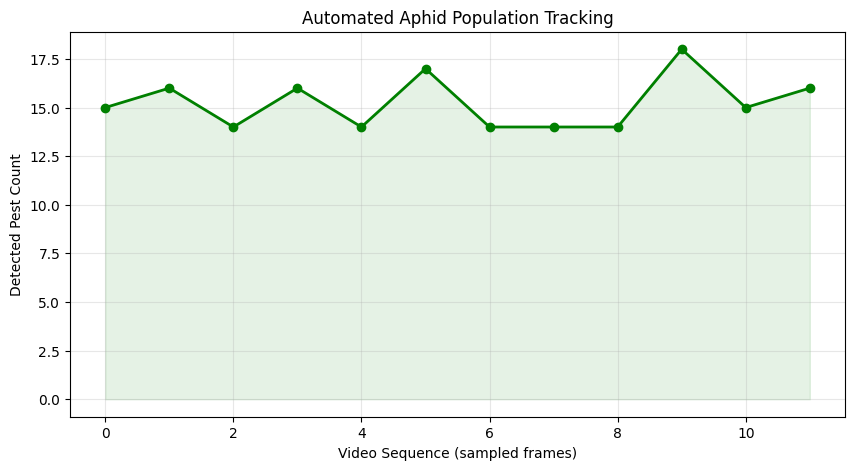

In [ ]:
counts = [len(d) for d in all_video_detections[::100]] # Sample every nth frame
time_steps = list(range(len(counts)))

plt.figure(figsize=(10, 5))
plt.plot(time_steps, counts, marker='o', linestyle='-', color='green', linewidth=2)
plt.fill_between(time_steps, counts, color='green', alpha=0.1)
plt.title("Automated Aphid Population Tracking")
plt.xlabel("Video Sequence (sampled frames)")
plt.ylabel("Detected Pest Count")
plt.grid(True, alpha=0.3)
plt.savefig("population_trend.png", dpi=300)
plt.show()

With CLIP - Image

In [ ]:
import cv2
import torch
import numpy as np
import supervision as sv
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# --- CONFIGURATION ---
SOURCE_IMAGE_PATH = "/content/data/whitefly7.jpg"
CLASSES = ['insect']
# CLIP Prompts: [Target, Noise/Distractor]
CLIP_PROMPTS = ["a whitefly insect on a leaf", "a piece of dust or glare"]
CLIP_THRESHOLD = 0.6

# 1. Load CLIP Model
print("Loading CLIP...")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 2. Load Image
image = cv2.imread(SOURCE_IMAGE_PATH)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 3. Initial Detection with GroundingDINO
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=enhance_class_name(CLASSES),
    box_threshold=0.3,
    text_threshold=0.2
)

# 4. Filter & Verify with CLIP
verified_indices = []
clip_scores = []

if len(detections) > 0:
    for i, xyxy in enumerate(detections.xyxy):
        # Crop detection
        x1, y1, x2, y2 = map(int, xyxy)
        crop = image[y1:y2, x1:x2]

        if crop.size == 0: continue

        # Prep for CLIP
        crop_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        inputs = clip_processor(text=CLIP_PROMPTS, images=crop_pil, return_tensors="pt", padding=True).to(DEVICE)

        with torch.no_grad():
            outputs = clip_model(**inputs)
            probs = outputs.logits_per_image.softmax(dim=1)
            target_prob = probs[0][0].item() # Probability of first prompt (Target)

        if target_prob > CLIP_THRESHOLD:
            verified_indices.append(i)
            clip_scores.append(target_prob)

# 5. Finalize Detections
if verified_indices:
    detections = detections[np.array(verified_indices)]

    # Optional: Segment with SAM only verified objects
    detections.mask = segment(
        sam_predictor=sam_predictor,
        image=image_rgb,
        xyxy=detections.xyxy
    )

    # 6. Visualization
    mask_annotator = sv.MaskAnnotator()
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    labels = [f"Verified {clip_val:.2f}" for clip_val in clip_scores]

    annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

    %matplotlib inline
    sv.plot_image(annotated_image, (16, 16))
    print(f"Total verified objects: {len(detections)}")
else:
    print("No objects passed CLIP verification.")

No CLIP

In [ ]:
import numpy as np
import cv2
import supervision as sv
import torch

# --- 1. SETTINGS & THRESHOLDS ---
SOURCE_VIDEO_PATH = "/content/data/aphids_vid.mp4"
TARGET_VIDEO_PATH = "/content/data/result2.mp4"
BOX_THRESHOLD = 0.3
TEXT_THRESHOLD = 0.2
CLASSES = ['insect on leaf']

# --- 2. INITIALIZE ANNOTATORS ---
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
label_annotator = sv.LabelAnnotator()

# --- 3. THE FRAME PROCESSOR ---
def process_frame(image: np.ndarray, index: int) -> np.ndarray:
    # Detect
    detections = grounding_dino_model.predict_with_classes(
        image=image,
        classes=enhance_class_name(class_names=CLASSES),
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD
    )

    # CRITICAL FIX: Filter out detections with None class_id
    if detections.class_id is not None:
        mask = detections.class_id != None
        detections = detections[mask]

    # If no valid objects found, return original frame
    if len(detections) == 0:
        return image

    # Segment (with PyTorch warning fix)
    # Note: If you still get warnings, we can wrap this in a context manager
    detections.mask = segment(
        sam_predictor=sam_predictor,
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        xyxy=detections.xyxy
    )

    # Annotate
    annotated_frame = image.copy()
    annotated_frame = mask_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)

    labels = [
        f"{CLASSES[int(class_id)]} {conf:.2f}"
        for class_id, conf in zip(detections.class_id, detections.confidence)
    ]

    return label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

# --- 4. EXECUTE ---
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=process_frame
)

Using Image Input

In [ ]:
# load image
image = cv2.imread(SOURCE_IMAGE_PATH)

# detect objects
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:.2f}"
    for class_id, confidence in zip(detections.class_id, detections.confidence)
]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels
)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))


In [ ]:
# load image (re-added for robustness after potential kernel restart or out-of-order execution)
import cv2
image = cv2.imread(SOURCE_IMAGE_PATH)

# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
label_annotator = sv.LabelAnnotator()

labels = [
    f"{CLASSES[class_id]} {confidence:.2f}"
    for class_id, confidence in zip(detections.class_id, detections.confidence)
]
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image,
    detections=detections,
    labels=labels
)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))

In [ ]:
print(len(detections))

In [ ]:
grid_size_dimension = math.ceil(math.sqrt(len(detections.mask)))

titles = [
    CLASSES[class_id]
    for class_id
    in detections.class_id
]

sv.plot_images_grid(
    images=detections.mask,
    titles=titles,
    grid_size=(grid_size_dimension, grid_size_dimension),
    size=(13, 10)
)

In [ ]:
def calculate_statistics(detections: sv.Detections, image_shape: Tuple[int, int]) -> dict:
    """Calculate detection statistics"""
    if len(detections) == 0:
        return {
            'count': 0,
            'avg_confidence': 0,
            'min_confidence': 0,
            'max_confidence': 0,
            'total_area_pixels': 0,
            'coverage_percent': 0
        }

    total_pixels = image_shape[0] * image_shape[1]

    # Calculate areas
    areas = []
    if detections.mask is not None:
        for mask in detections.mask:
            areas.append(np.sum(mask))
    else:
        for box in detections.xyxy:
            w = box[2] - box[0]
            h = box[3] - box[1]
            areas.append(w * h)

    total_area = sum(areas)

    return {
        'count': len(detections),
        'avg_confidence': round(float(np.mean(detections.confidence)),4),
        'min_confidence': round(float(np.min(detections.confidence)),4),
        'max_confidence': round(float(np.max(detections.confidence)),4),
        'total_area_pixels': int(total_area),
        'coverage_percent': round(float(total_area / total_pixels * 100),4),
        'avg_area_pixels': round(float(np.mean(areas)) if areas else 0,4)
    }
statistics = calculate_statistics(detections, image_shape=image.shape[:2])
for i in statistics:
  print(f"{i}: {statistics[i]}")

In [ ]:
def plot_confidence_distribution(detections: sv.Detections):
    """Plot confidence score distribution"""
    if len(detections) == 0:
        return

    plt.figure(figsize=(10, 5))
    plt.hist(detections.confidence, bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('Confidence Score')
    plt.ylabel('Count')
    plt.title(f'Confidence Distribution (n={len(detections)})')
    plt.grid(True, alpha=0.3)
    plt.show()
plot_confidence_distribution(detections)

# with Sahi

In [ ]:
def dino_sahi_callback(image_slice: np.ndarray) -> sv.Detections:
    return grounding_dino_model.predict_with_classes(
        image=image_slice,
        classes=enhance_class_name(CLASSES),
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )


slicer = sv.InferenceSlicer(
    callback=dino_sahi_callback,
    slice_wh=(512, 512),
    overlap_wh=(102, 102)
)


detections_sahi = slicer(image)

detections_sahi = detections_sahi.with_nms(threshold=0.5)


box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:.2f}"
    for class_id, confidence in zip(detections_sahi.class_id, detections_sahi.confidence)
]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections_sahi)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections_sahi,
    labels=labels
)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

In [ ]:
# convert detections to masks
detections_sahi.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections_sahi.xyxy
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
label_annotator = sv.LabelAnnotator()

labels = [
    f"{CLASSES[class_id]} {confidence:.2f}"
    for class_id, confidence in zip(detections_sahi.class_id, detections_sahi.confidence)
]
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections_sahi)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections_sahi)
annotated_image = label_annotator.annotate(
    scene=annotated_image,
    detections=detections_sahi,
    labels=labels
)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))

In [ ]:
print(len(detections_sahi))

In [ ]:
grid_size_dimension = math.ceil(math.sqrt(len(detections_sahi.mask)))

titles = [
    CLASSES[class_id]
    for class_id
    in detections_sahi.class_id
]

sv.plot_images_grid(
    images=detections_sahi.mask,
    titles=titles,
    grid_size=(grid_size_dimension, grid_size_dimension),
    size=(13, 10)
)

In [ ]:
def calculate_statistics(detections: sv.Detections, image_shape: Tuple[int, int]) -> dict:
    """Calculate detection statistics"""
    if len(detections) == 0:
        return {
            'count': 0,
            'avg_confidence': 0,
            'min_confidence': 0,
            'max_confidence': 0,
            'total_area_pixels': 0,
            'coverage_percent': 0
        }

    total_pixels = image_shape[0] * image_shape[1]

    # Calculate areas
    areas = []
    if detections.mask is not None:
        for mask in detections.mask:
            areas.append(np.sum(mask))
    else:
        for box in detections.xyxy:
            w = box[2] - box[0]
            h = box[3] - box[1]
            areas.append(w * h)

    total_area = sum(areas)

    return {
        'count': len(detections),
        'avg_confidence': round(float(np.mean(detections.confidence)),4),
        'min_confidence': round(float(np.min(detections.confidence)),4),
        'max_confidence': round(float(np.max(detections.confidence)),4),
        'total_area_pixels': int(total_area),
        'coverage_percent': round(float(total_area / total_pixels * 100),4),
        'avg_area_pixels': round(float(np.mean(areas)) if areas else 0,4)
        }
statistics = calculate_statistics(detections_sahi, image_shape=image.shape[:2])
for i in statistics:
  print(f"{i}: {statistics[i]}")

In [ ]:
def plot_confidence_distribution(detections: sv.Detections, save_path: Optional[str] = None):
    """Plot confidence score distribution"""
    if len(detections) == 0:
        return

    plt.figure(figsize=(10, 5))
    plt.hist(detections.confidence, bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('Confidence Score')
    plt.ylabel('Count')
    plt.title(f'Confidence Distribution (n={len(detections)})')
    plt.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
plot_confidence_distribution(detections_sahi)

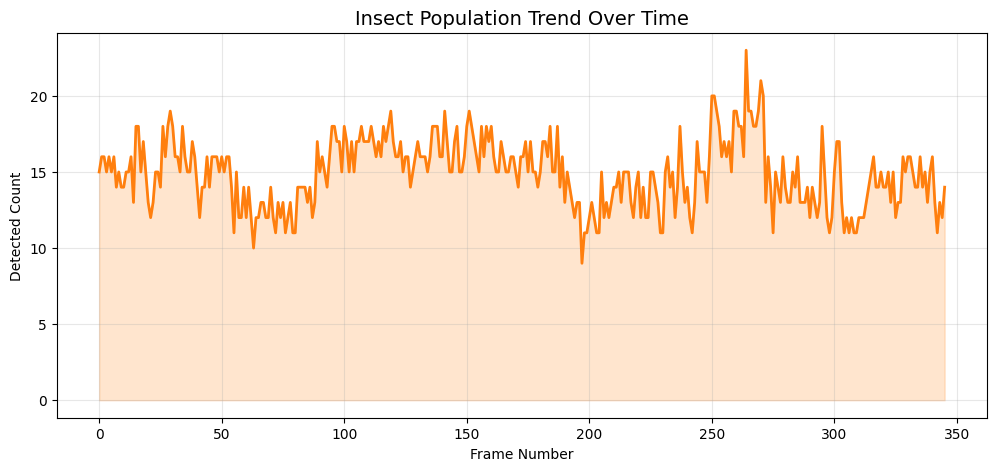

KeyError: 'clip_score'

<Figure size 1200x500 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Convert stats to a DataFrame for easy plotting
df = pd.DataFrame(video_stats)

# 2. CREATE RESULT 1: Population Trend
plt.figure(figsize=(12, 5))
plt.plot(df['frame'], df['count'], color='#ff7f0e', linewidth=2)
plt.fill_between(df['frame'], df['count'], color='#ff7f0e', alpha=0.2)
plt.title('Insect Population Trend Over Time', fontsize=14)
plt.xlabel('Frame Number')
plt.ylabel('Detected Count')
plt.grid(True, alpha=0.3)
plt.show()

# 3. CREATE RESULT 2: CLIP Confidence Stability
plt.figure(figsize=(12, 5))
plt.scatter(df['frame'], df['clip_score'], c=df['clip_score'], cmap='viridis', s=10)
plt.title('CLIP Verification Confidence (Stability Check)', fontsize=14)
plt.ylabel('CLIP Score')
plt.ylim(0, 1)
plt.show()

# 4. CREATE RESULT 3: Spatial Heatmap (Where are the pests?)
# We take the last frame of the video as the background
heatmap_frame = image.copy() # Or load a fresh frame from the video
combined_detections = sv.Detections.merge(all_video_detections)
annotated_heatmap = heatmap_annotator.annotate(scene=heatmap_frame, detections=combined_detections)

print("--- FINAL SUMMARY STATISTICS ---")
print(f"Average Count: {df['count'].mean():.2f}")
print(f"Peak Infestation (Max Count): {df['count'].max()}")
print(f"Total Unique Detections Processed: {len(combined_detections)}")

sv.plot_image(annotated_heatmap, (12, 12))